In [15]:
import os, time
from math import ceil

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from torchvision import datasets, transforms
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.cuda as cuda
import torch

# For progress
from tqdm import tnrange, tqdm_notebook
from time import sleep


In [2]:
use_gpu = cuda.is_available()
# use_gpu=False

# Learning to generate MNIST digits using a De-Convolutional Generator Discriminator model

In [3]:
class Generator(nn.Module):
    # Initialize with random variables from normal distribution    
    def weight_init(self, mean, std):
        for i in self._modules:
            if isinstance(self._modules[i], nn.ConvTranspose2d):
                self._modules[i].weight.data.normal_(mean, std)
                self._modules[i].bias.data.zero_()
                
    def __init__(self, n_channels=100, init=True, reuse=False, mean=0.0, std=0.02 ):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #1st hidden layer
            nn.ConvTranspose2d(in_channels=n_channels, # "Deconvolutional" layer 
                               out_channels=1024,
                               kernel_size=4,
                               stride=1,
                               padding=0,
#                                bias=False
                              ),
            nn.BatchNorm2d(1024, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #2nd hidden layer
            nn.ConvTranspose2d(in_channels=1024,
                               out_channels=512,
                               kernel_size=4,
                               stride=1,
                               padding=0,
#                                bias=False
                              ),
            nn.BatchNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #3rd hidden layer
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=4,
                               stride=2,
                               padding=0,
#                                bias=False
                              ),
            nn.BatchNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            #4th hidden layer
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4,
                               stride=2,
                               padding=1,
#                                bias=False
                              ),
            nn.BatchNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
            
            # output layer
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=1,
                               kernel_size=4,
                               stride=2,
                               padding=1,
#                                bias=False
                              ),
            nn.Tanh()
        )
        if init: self.weight_init(mean, std)
            
    def forward(self, x):
        output = self.main(x)
        return output

In [4]:
class Discriminator(nn.Module):
    # Initialize with random variables from normal distribution    
    def weight_init(self, mean, std):
        for i in self._modules:
            if isinstance(self._modules[i], nn.Conv2d):
                self._modules[i].weight.data.normal_(mean, std)
                self._modules[i].bias.data.zero_()
                
    def __init__(self, reuse=False, n_channels=1, init=True, mean=0.0, std=0.02):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #1st hidden layer
            nn.Conv2d(in_channels=n_channels,
                      out_channels=128,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            
            #2nd hidden layer
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            
            #3rd hidden layer
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=4,
                      stride=2,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),
            
            #4th hidden layer
            nn.Conv2d(in_channels=512,
                      out_channels=1024,
                      kernel_size=4,
                      stride=2,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.2),
            
            #output layer
            nn.Conv2d(in_channels=1024,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.Sigmoid()
            
        )
        if init: self.weight_init(mean, std)
                
    def forward(self, y):
        output = self.main(y)
        return output
        

In [5]:
# G = Generator().cuda()
# for i in range(5): imshow(torchvision.utils.make_grid(G(Variable(torch.rand([10, 100, 1, 1])).cuda()).data))
# D = Discriminator().cuda()
# print(D(G(Variable(torch.rand([1, 100, 1, 1])).cuda())))


In [6]:
# define transform
def get_data(img_size = 64, batch_size=128):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform, )
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1 )
    # train_data_iter = iter(torch.Tensor(trainloader))
#     testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#     testloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=1 )

    classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
    return trainloader, classes

torch.Size([128, 1, 64, 64])


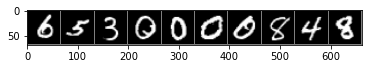

  6   5   3   0   0   0   0   8   4   8


Process Process-1:
Traceback (most recent call last):
  File "/home/sharan/anaconda2/envs/tfgpu/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/sharan/anaconda2/envs/tfgpu/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sharan/anaconda2/envs/tfgpu/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/sharan/anaconda2/envs/tfgpu/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/home/sharan/anaconda2/envs/tfgpu/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/sharan/anaconda2/envs/tfgpu/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/sharan/anaconda2/envs/tfgpu/lib/python3.6/multiprocessing/connection.py", line 379,

In [7]:
def imshow(img, use_gpu=use_gpu):
    if use_gpu: img=img.cpu()
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
#     Permute the axes 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
trainloader, classes = get_data()
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
images, labels = images[0:10], labels[0:10]

imshow(torchvision.utils.make_grid(images, nrow=10))
print(" ".join("%3s" % classes[labels[j]] for j in range(len(labels))))

In [8]:
def g_sampler(batch_size):
    return torch.randn([batch_size, 100, 1, 1])
# print(g_sampler().size())
# print(g_sampler().squeeze())

In [9]:
G = Generator()
D = Discriminator()
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [24]:
if not os.path.isdir('DCGAN_MNIST_results'):
    os.mkdir('DCGAN_MNIST_results')
if not os.path.isdir('DCGAN_MNIST_results/Random_results'):
    os.mkdir('DCGAN_MNIST_results/Random_results')
if not os.path.isdir('DCGAN_MNIST_results/Fixed_results'):
    os.mkdir('DCGAN_MNIST_results/Fixed_results')

In [25]:
def save_checkpoint(state, isfinal, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if isfinal:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [26]:
def training(G, D, criterion, d_optimizer, g_optimizer, g_sampler, batch_size=128, num_epochs=20, epoch_int=10, d_steps=1, g_steps=1, use_gpu=use_gpu):

    print("Image processing starting")
    
    trainloader, _ = get_data(img_size = 64, batch_size=batch_size)
    dataiter = iter(trainloader)
    print("Image processing complete")
    if use_gpu:
        G = G.cuda()
        D = D.cuda()
        print("GPU in use!")
    else:
        print("CPU in use :(")
    
    print("Training Starting")
    start_time = time.time()    
    for epoch in tnrange(num_epochs, desc='Epoch'):
        epoch_start_time = time.time()
        for j in tqdm_notebook(range(ceil(60000/batch_size)), desc='Batch', leave=False):
            if j<460: continue
            d_real_images, _ = dataiter.next()
            batch_size_i = d_real_images.size()[0]
            for d_i in range(d_steps):
    #                 batch_start_time = time.time()
                D.zero_grad()

                #on real
                d_real_images = Variable(d_real_images)
                if use_gpu: d_real_images = d_real_images.cuda()
                d_real_decision = D(d_real_images)
                d_real_ones = Variable(torch.ones([batch_size_i]))
                if use_gpu: d_real_ones = d_real_ones.cuda()
                d_real_error = criterion(d_real_decision.squeeze(), d_real_ones)
                d_real_error.backward()

                # on fake
                d_gen_input = Variable(g_sampler(batch_size=batch_size_i))
                if use_gpu: d_gen_input = d_gen_input.cuda() 
                d_fake_images = G(d_gen_input).detach()
                d_fake_decision = D(d_fake_images)
                d_fake_zeros = Variable(torch.zeros([batch_size_i]))
                if use_gpu: d_fake_zeros = d_fake_zeros.cuda()
                d_fake_error = criterion(d_fake_decision.squeeze(), d_fake_zeros)
                d_fake_error.backward()

                d_optimizer.step()
            for g_i in range(g_steps):
                G.zero_grad()

                gen_input = Variable(g_sampler(batch_size=batch_size_i))
                if use_gpu: gen_input = gen_input.cuda()
                g_fake_images = G(gen_input)
                fake_decision = D(g_fake_images)
                fake_decision_ones = Variable(torch.ones([batch_size_i]))
                if use_gpu: fake_decision_ones = fake_decision_ones.cuda()
                g_error = criterion(fake_decision.squeeze(), fake_decision_ones)
                g_error.backward()
                g_optimizer.step()
    #             batch_end_time = time.time()
    #             batch_time = batch_end_time - batch_start_time
    #             print ("%s"%(time.strftime("%M mins %S secs", time.gmtime(batch_time))))
        save_checkpoint({
            'epoch': epoch + 1,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'g_optimizer' : g_optimizer.state_dict(),
            'd_optimizer' : d_optimizer.state_dict(),
        }, isfinal=False)    
        
        
        epoch_end_time = time.time()   
        epoch_time = epoch_end_time - epoch_start_time
        epoch_time = time.strftime("%M mins %S secs", time.gmtime(epoch_time))
        print("%2s/%2s - epochTime: %10s | "%(epoch+1, num_epochs, epoch_time))
        if epoch % epoch_int == 0:
#             print("%3s / %3s epochs"% (epoch, num_epochs))
            imshow(torchvision.utils.make_grid(g_fake_images.data[0:3]))
    end_time = time.time()
    train_time = end_time-start_time
    train_time = time.strftime("%H hrs %M mins %S secs", time.gmtime(train_time))
    print("Training Time: %s"%(train_time))
    print("Training Complete!")
    print("Saving Final Checkpoint")
    save_checkpoint({
            'epoch': epoch + 1,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'g_optimizer' : g_optimizer.state_dict(),
            'd_optimizer' : d_optimizer.state_dict(),
        }, isfinal=True)    
    print("Checkpoint Saved!")

Image processing starting
Image processing complete
GPU in use!
Training Starting


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


461/|/ 98%|| 461/469 [00:20<00:00, 22.79it/s] 1/ 3 - epochTime: 00 mins 29 secs | 


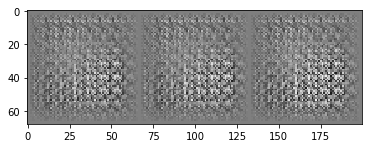

Widget Javascript not detected.  It may not be installed or enabled properly.


461/|/ 98%|| 461/469 [00:20<00:00, 21.96it/s] 2/ 3 - epochTime: 00 mins 27 secs | 


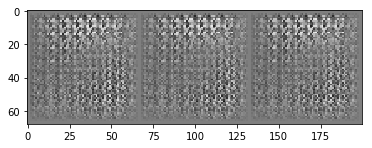

Widget Javascript not detected.  It may not be installed or enabled properly.


461/|/ 98%|| 461/469 [00:13<00:00, 34.71it/s] 3/ 3 - epochTime: 00 mins 27 secs | 


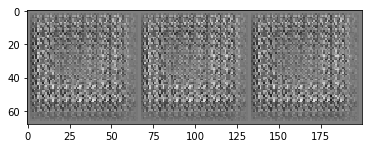


Training Time: 00 hrs 01 mins 24 secs
Training Complete!
Saving Final Checkpoint


NameError: name 'shutil' is not defined

In [27]:
training(G=G,
         D=D,
         criterion=criterion,
         d_optimizer=d_optimizer,
         g_optimizer=g_optimizer,
         g_sampler=g_sampler,
         batch_size=128,
         num_epochs=3,
         epoch_int=1,
        )

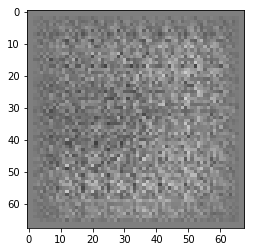

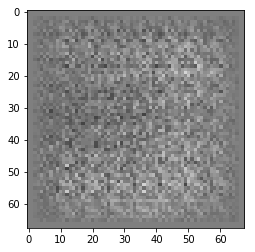

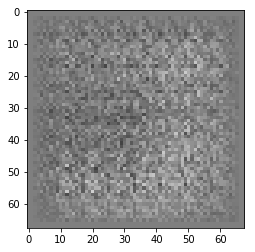

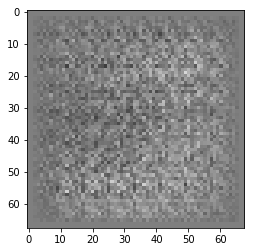

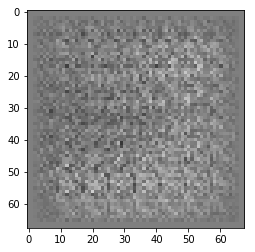

In [21]:
for i in range(5): imshow(torchvision.utils.make_grid(G(Variable(torch.randn([1, 100, 1, 1]), volatile=True).cuda()).data))

In [ ]:
torch.cuda.empty_cache()

### TODO:
- **DONE** Make GPU ready
- **DONE** Fix training to use all data.
- Add Noise.
- Collect Data during training.
- Use data collected to make graphs
- Output graphs to directory
- Save training values